<a href="https://colab.research.google.com/github/saimahesh-ai/test-colab/blob/main/FriendSuggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1RMTWpYws8g92bnTlXli6QkiqFGNzQRSu
!gdown 1RMggHHpcHoCncMRCdgbr-vQgTWK5fMYk

Downloading...
From: https://drive.google.com/uc?id=1RMTWpYws8g92bnTlXli6QkiqFGNzQRSu
To: /content/details.csv
100% 578/578 [00:00<00:00, 799kB/s]
Downloading...
From: https://drive.google.com/uc?id=1RMggHHpcHoCncMRCdgbr-vQgTWK5fMYk
To: /content/edgelist.csv
100% 321/321 [00:00<00:00, 118kB/s]


In [2]:
import pandas as pd

people_df = pd.read_csv('details.csv')

people_df

,name,details
0,mahesh,stanford university
1,abhijit,northeastern university
2,navya,texas tech university
3,mahi,"university of california,san diego"
4,harish,university of north texas
5,pavan,columbia university
6,sreekar,"university of texas, Austin"
7,ram charan,harvard university
8,kavya,university of san antonio
9,tarun,illinois institute of technology


In [3]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

edgelist = pd.read_csv('edgelist.csv')

edgelist

,FROM,TO
0,abhijit,kavya
1,mahi,navya
2,harsha,sreekar
3,harish,pavan
4,mahesh,ram charan
5,mahesh,ashwin
6,akruti,shiva
7,akruti,srujana
8,akhila,sathvika
9,akhila,divya


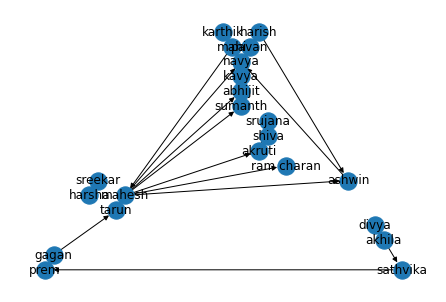

In [4]:
g = nx.DiGraph()

# Add nodes
for k in set(edgelist.FROM.append(edgelist.TO)):
  g.add_node(k)

# Add edges
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1])

nx.draw(g, nx.planar_layout(g), with_labels=True)
plt.show()

In [5]:
import numpy as np
import scipy as sp
import scipy.sparse

def pagerank(G, alpha=0.85, max_iter=100, tol=1.0e-6, weight="weight"):
  # checking if nodes are present in graph or else returning
  N = len(G)
  if N == 0:
    return {}

  # creating list of nodes in Graph G
  nodelist = list(G)

  # creating a adjacency matrix
  M = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, weight=weight, dtype=float)

  # performing sum across rows and flattening matrix
  S = np.array(M.sum(axis=1)).flatten()

  # checking for zeros in S later applying reciprocal of S
  S[S != 0] = 1.0 / S[S != 0]

  # a sparse matrix from diagonals of S
  Q = sp.sparse.spdiags(S.T, 0, *M.shape, format="csr")

  # applying matrix multiplication of Sparse diagonal matrix and adjancency matrix for eigen vector
  M = Q * M

  # initial vector
  x = np.repeat(1.0 / N, N)

  # The outedges to be assigned to any dangling nodes, i.e., nodes without any outedges. The dict key is the node the outedge points to and the dict value is the weight of that outedge. By default, dangling nodes are given outedges according to the personalization vector (uniform if not specified) This must be selected to result in an irreducible transition matrix. It may be common to have the dangling dict to be the same as the personalization dict.
  # identifying dangling nodes 
  is_dangling = np.where(S == 0)[0]

  # power iteration: make up to max_iter iterations
  for _ in range(max_iter):
    xlast = x
    # pagerank formula
    x = alpha * (x * M + sum(x[is_dangling]) * x) + (1 -alpha) * x
    # check convergence, l1 norm
    err = np.absolute(x - xlast).sum()
    if err < N * tol:
      return dict(zip(nodelist, map(float, x)))
  raise nx.PowerIterationFailedConvergence(max_iter)

In [6]:
pagerank_mapper = pagerank(g)
pagerank_mapper

{'srujana': 0.020909896708609266,
 'sumanth': 0.03536541721033987,
 'prem': 1.734103749195827e-06,
 'kavya': 0.041819788922043175,
 'tarun': 1.7797211174167733e-07,
 'akruti': 0.03536541721033987,
 'mahesh': 0.17943637831740422,
 'pavan': 9.123364354745313e-08,
 'navya': 0.256623131591074,
 'karthik': 4.495175353228999e-09,
 'sathvika': 9.123364354745313e-08,
 'harish': 4.495175353228999e-09,
 'ashwin': 0.03536550394880805,
 'harsha': 4.495175353228999e-09,
 'sreekar': 1.7797211174167733e-07,
 'ram charan': 0.03536541721033987,
 'mahi': 0.3034713487373133,
 'shiva': 0.020909896708609266,
 'divya': 9.123364354745313e-08,
 'abhijit': 0.03536541721033987,
 'akhila': 4.495175353228999e-09,
 'gagan': 4.495175353228999e-09}

In [7]:
people_df['pagerank'] = people_df.name.map(pagerank_mapper)

In [8]:
people_mapper = dict(enumerate(people_df.name.unique()))
reverse_people_mapper = {v:k for k, v in people_mapper.items()}

In [9]:
import pandas as pd
import numpy as np
import collections
import re

docs = [re.sub(' +', ' ', re.sub(r"[^a-zA-Z0-9]", " ", doc.lower().strip())) for doc in people_df.details]

wordlist = list(set(' '.join(docs).split(' ')))

def calculateBOW(wordset,l_doc):
  tf_diz = dict.fromkeys(wordset,0)
  for word in l_doc.split(' '):
      tf_diz[word]=l_doc.count(word)
  return tf_diz

mod_people_df_cols = [calculateBOW(wordlist, doc) for doc in docs]

In [10]:
mod_people_df = pd.DataFrame(mod_people_df_cols)

mod_people_df.fillna(0, inplace=True)

mod_people_df['name'] = mod_people_df.index

mod_people_df['pagerank'] = people_df.pagerank

mod_people_df

,diego,rice,institute,florida,stanford,austin,tech,columbia,carolina,arizona,...,harvard,san,north,kent,texas,michigan,northeastern,antonio,name,pagerank
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.794364e-01
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3.536542e-02
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,2,2.566231e-01
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,3,3.034713e-01
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,4,4.495175e-09
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5,9.123364e-08
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,6,1.779721e-07
7,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,7,3.536542e-02
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,8,4.181979e-02
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,1.779721e-07


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(mod_people_df)
scaled_data = scaler.transform(mod_people_df)

scaled_data

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.91279464e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 6.25000000e-02, 1.16536251e-01],
       [0.00000000e+00

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(scaled_data)

In [13]:
def get_suggestions(G,model,scaled_data,reverse_people_mapper,find_friends_for):
    distances, indices = model.kneighbors([scaled_data[reverse_people_mapper.get(find_friends_for)].tolist()])
    return list(mod_people_df.iloc[indices[0]].name.map(people_mapper).iloc[1:])

get_suggestions(g,nbrs,scaled_data,reverse_people_mapper,'gagan')

['akhila',
 'srujana',
 'sathvika',
 'ram charan',
 'pavan',
 'abhijit',
 'mahesh',
 'shiva',
 'sumanth']

In [14]:
def follows_back(G,a,b):
    return G.has_edge(b,a)

follows_back(g,'mahesh','mahi')

True

In [15]:
def get_true_suggestions(G,find_friends_for,suggestions,n=5):
    return list(filter(lambda suggestion: not follows_back(G,find_friends_for,suggestion),suggestions))[:n]

get_true_suggestions(g,'gagan',get_suggestions(g,nbrs,scaled_data,reverse_people_mapper,'gagan'))

['akhila', 'srujana', 'sathvika', 'ram charan', 'pavan']